In [1]:
##FILTERS AND INITIAL IMPORT
import pm4py
from datetime import datetime

# Step 1: Load the event log
log = pm4py.read_xes('InternationalDeclarations.xes', return_legacy_log_object=True)

# Import variants filtering and case statistics
from pm4py.algo.filtering.log.variants import variants_filter
from pm4py.statistics.traces.generic.log import case_statistics

# Convert log to a Pandas dataframe (necessary for some newer versions of pm4py)
df_log = pm4py.convert_to_dataframe(log)

# Step 1: Discover variants and their frequencies
variants_count = case_statistics.get_variant_statistics(df_log)

# Step 2: Sort variants by frequency in descending order
sorted_variants = sorted(variants_count, key=lambda x: x['count'], reverse=True)

# Step 3: Calculate the top 10% of variants
top_10_percent_index = int(len(sorted_variants) * 0.1)  # 10% of variants
top_10_percent_variants = sorted_variants[:top_10_percent_index]

# Step 4: Extract the names of the top 10% variants
top_10_variant_names = {variant['variant'] for variant in top_10_percent_variants}

# Step 5: Filter the log to include only the top 10% variants
filtered_log = variants_filter.apply(log, top_10_variant_names)

# Print the results
print(f"Number of variants in the original log: {len(variants_count)}")
print(f"Number of variants in the top 10%: {len(top_10_percent_variants)}")
print(f"Number of traces in the filtered log: {len(filtered_log)}")


c:\Users\z004zabd\OneDrive - Siemens AG\Desktop\Test\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
parsing log, completed traces :: 100%|██████████| 6449/6449 [00:02<00:00, 2270.52it/s]


Number of variants in the original log: 753
Number of variants in the top 10%: 75
Number of traces in the filtered log: 5232


In [2]:
##PROCESS MINING SUMMARY
import numpy as np
import statistics

# Step 1: Count the number of traces in the filtered log
num_traces = len(filtered_log)

# Step 2: Extract cycle times (start to end duration of each trace)
cycle_times = []

for trace in filtered_log:
    if len(trace) > 1:
        start_time = trace[0]["time:timestamp"]
        end_time = trace[-1]["time:timestamp"]
        cycle_time = (end_time - start_time).total_seconds() / 86400  # Convert seconds to days
        cycle_times.append(cycle_time)

# Step 3: Calculate average cycle time
avg_cycle_time = np.mean(cycle_times) if cycle_times else None

# Step 4: Calculate average number of events per trace
avg_events_per_trace = statistics.mean([len(trace) for trace in filtered_log])

# Print consolidated output
print(f"""
Process Mining Summary
-------------------------------------
Number of traces: {num_traces}
Average cycle time: {avg_cycle_time:.2f} days
Average number of events per trace: {avg_events_per_trace:.2f}
""")



Process Mining Summary
-------------------------------------
Number of traces: 5232
Average cycle time: 82.77 days
Average number of events per trace: 10.76



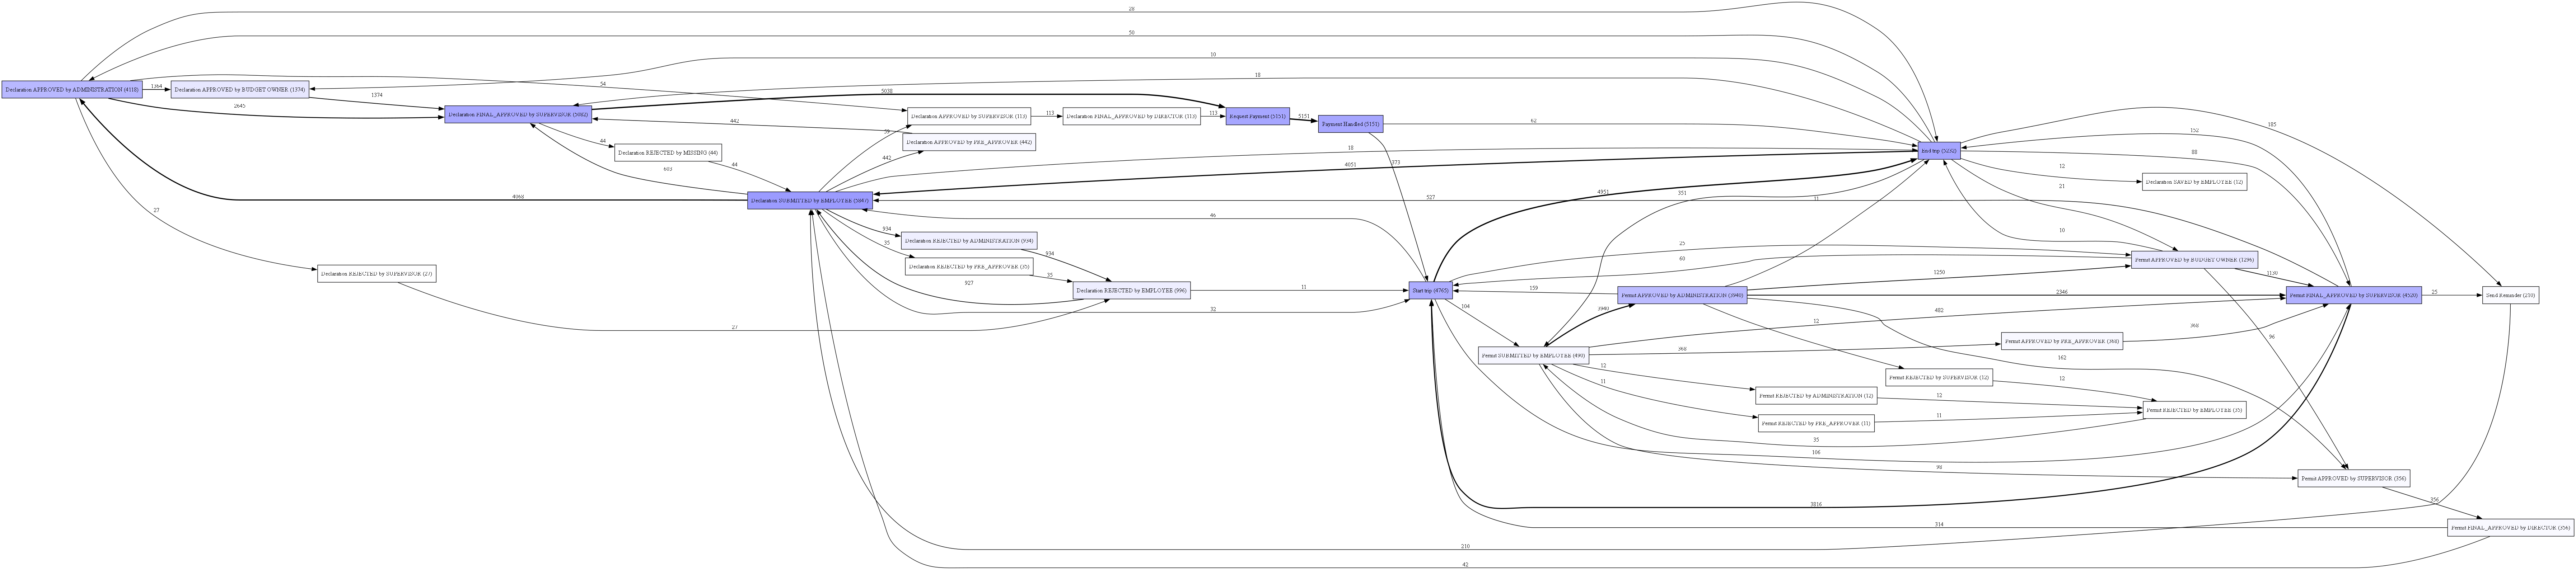

In [3]:
##CREATING DFG
from pm4py.visualization.petri_net import visualizer as pn_visualizer
dfg, start_activities, end_activities = pm4py.discover_dfg(filtered_log)
gviz = pm4py.visualization.dfg.visualizer.apply(dfg)
pn_visualizer.view(gviz)

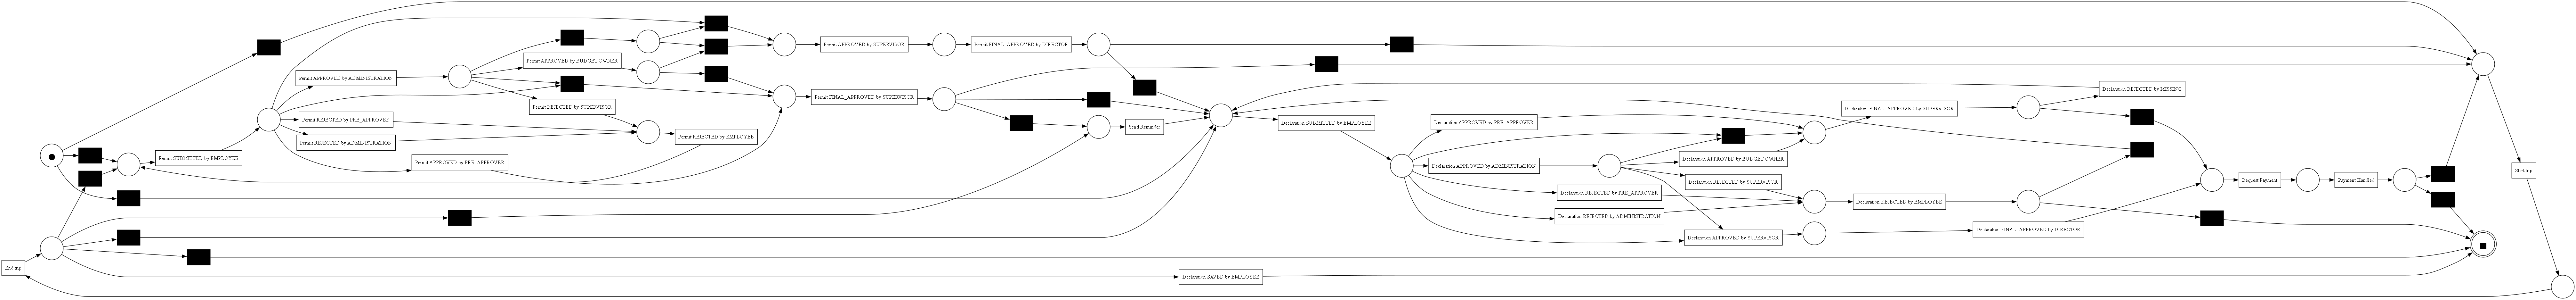

In [4]:
##HEURISTICS & VISUALISING PETRI NET
# net, im, fm = pm4py.discover_petri_net_alpha(filtered_log)   ## alfa miner ig
# from pm4py.algo.discovery.heuristics import algorithm as heuristics_miner
 
# # Discover the Petri Net using the Heuristic Miner
# net, im, fm = heuristics_miner.apply(filtered_log)

from pm4py.algo.discovery.heuristics import algorithm as heuristics_miner
from pm4py.visualization.petri_net import visualizer as pn_visualizer
 
# Parameters for Heuristics Miner
parameters = {
    "dependency_thresh": 0.8,  # Dependency threshold
    "and_measure_thresh": 0.65,  # AND threshold
    "loop_length_two_thresh": 0.5,  # Loop threshold
    "noise_thresh": 0.2,  # Noise threshold
}
 
# Apply Heuristics Miner with parameters
net, im, fm = heuristics_miner.apply(filtered_log, parameters=parameters)
 
# Visualize the resulting Petri net
gviz = pn_visualizer.apply(net, im, fm)
pn_visualizer.view(gviz)


In [5]:
# gviz = pm4py.visualization.petri_net.visualizer.apply(net, im, fm)
# pn_visualizer.view(gviz)


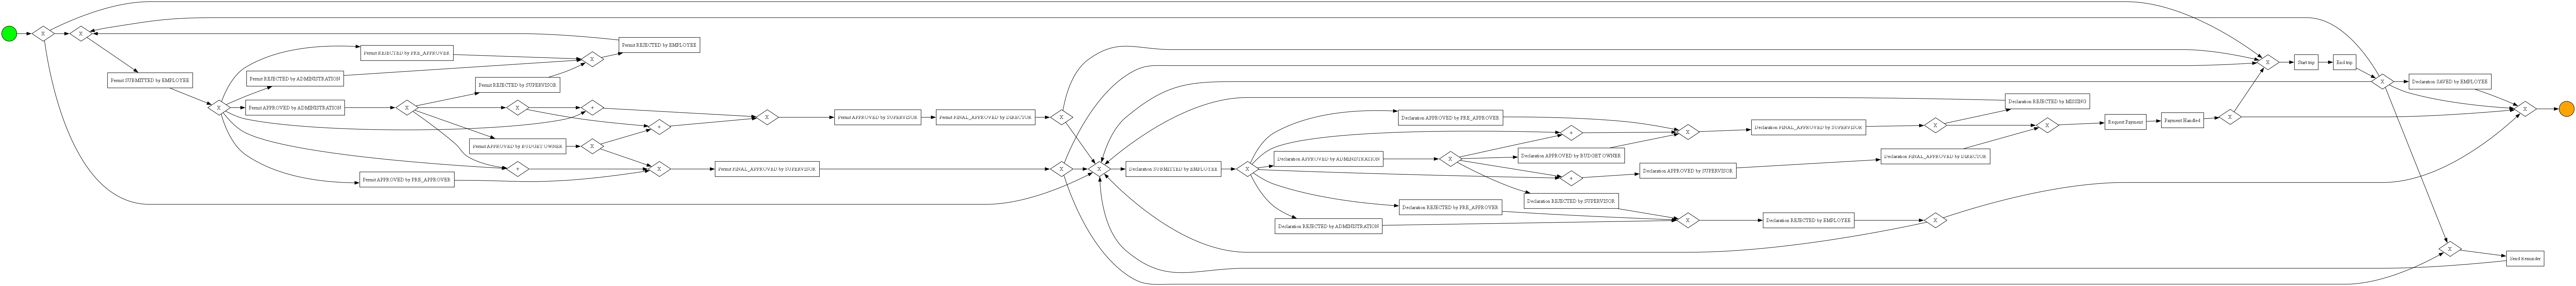

In [6]:
##BPMN VISUALIZATION
bpmn = pm4py.convert_to_bpmn(net, im, fm)

gviz = pm4py.visualization.bpmn.visualizer.apply(bpmn)
pn_visualizer.view(gviz)

In [7]:
##EXPORTING BPMN MODEL FOR BIPM
# Define the BPMN file path
bpmn_file_path = "process_model.bpmn"

# Export the BPMN model to a BPMN file
pm4py.write_bpmn(bpmn, bpmn_file_path)

print(f"BPMN file exported to: {bpmn_file_path}")

BPMN file exported to: process_model.bpmn


In [20]:
## VARIANT ANALYSIS
from pm4py.algo.filtering.log.variants import variants_filter

# Extract variants from the filtered log
variants = variants_filter.get_variants(filtered_log)

# Sort variants by count (descending order) and keep only the top 5
sorted_variants = sorted(variants.items(), key=lambda x: len(x[1]), reverse=True)[:5]

# Display the top 5 variants with their counts
print("Top 5 Most Common Variants and Their Case Counts:")
for i, (variant, cases) in enumerate(sorted_variants, start=1):
    print(f"{i}. Variant: {variant}, Count: {len(cases)}")


Top 5 Most Common Variants and Their Case Counts:
1. Variant: ('Permit SUBMITTED by EMPLOYEE', 'Permit APPROVED by ADMINISTRATION', 'Permit FINAL_APPROVED by SUPERVISOR', 'Start trip', 'End trip', 'Declaration SUBMITTED by EMPLOYEE', 'Declaration APPROVED by ADMINISTRATION', 'Declaration FINAL_APPROVED by SUPERVISOR', 'Request Payment', 'Payment Handled'), Count: 1369
2. Variant: ('Permit SUBMITTED by EMPLOYEE', 'Permit APPROVED by ADMINISTRATION', 'Permit APPROVED by BUDGET OWNER', 'Permit FINAL_APPROVED by SUPERVISOR', 'Start trip', 'End trip', 'Declaration SUBMITTED by EMPLOYEE', 'Declaration APPROVED by ADMINISTRATION', 'Declaration APPROVED by BUDGET OWNER', 'Declaration FINAL_APPROVED by SUPERVISOR', 'Request Payment', 'Payment Handled'), Count: 624
3. Variant: ('Permit SUBMITTED by EMPLOYEE', 'Permit FINAL_APPROVED by SUPERVISOR', 'Start trip', 'End trip', 'Declaration SUBMITTED by EMPLOYEE', 'Declaration FINAL_APPROVED by SUPERVISOR', 'Request Payment', 'Payment Handled'), Coun

In [9]:
##LEAST FREQUENT VARIATION
from pm4py.algo.filtering.log.variants import variants_filter
from pm4py.objects.log.util import interval_lifecycle
from pm4py.objects.conversion.log import converter as log_converter
from pm4py.visualization.bpmn import visualizer as bpmn_visualizer
from pm4py.objects.conversion.process_tree import converter as pt_converter
from pm4py.algo.discovery.inductive import algorithm as inductive_miner
 
# Step 1: Get variants from the filtered log
variants = variants_filter.get_variants(filtered_log)
 
# Step 2: Find the variant with the minimum count
least_frequent_variant = None
min_count = float('inf')  # Start with infinity
 
for variant, cases in variants.items():
    if len(cases) < min_count:
        least_frequent_variant = variant
        min_count = len(cases)
 
print(f"\nLeast frequent variant: {least_frequent_variant} (Count: {min_count})")
 
# Step 3: Create a new log containing only cases of the least frequent variant
least_frequent_variant_cases = variants[least_frequent_variant]
least_frequent_variant_log = pm4py.objects.log.obj.EventLog()
 
for case in least_frequent_variant_cases:
    least_frequent_variant_log.append(case)
 
# Step 4: Discover the process model (Process Tree -> Petri net -> BPMN)
process_tree = inductive_miner.apply(least_frequent_variant_log, variant=inductive_miner.Variants.IMf)
net, im, fm = pt_converter.apply(process_tree)
 
# Step 5: Convert to BPMN
bpmn_model = pm4py.convert_to_bpmn(net, im, fm)
 
# Step 6: Visualize the BPMN
bpmn_visualizer.apply(bpmn_model)
 
# Step 7: Export BPMN to a file
bpmn_file_path = "least_frequent_variant.bpmn"
pm4py.write_bpmn(bpmn_model, bpmn_file_path)
 
print(f"BPMN file for the least frequent variant exported to: {bpmn_file_path}")


Least frequent variant: ('Start trip', 'Permit SUBMITTED by EMPLOYEE', 'Permit APPROVED by ADMINISTRATION', 'Permit APPROVED by SUPERVISOR', 'Permit FINAL_APPROVED by DIRECTOR', 'Declaration SUBMITTED by EMPLOYEE', 'Declaration APPROVED by ADMINISTRATION', 'Declaration FINAL_APPROVED by SUPERVISOR', 'Request Payment', 'Payment Handled', 'End trip') (Count: 10)
BPMN file for the least frequent variant exported to: least_frequent_variant.bpmn


In [10]:
##MOST FREQUENT VARIATION
from pm4py.algo.filtering.log.variants import variants_filter
from pm4py.objects.log.util import interval_lifecycle
from pm4py.objects.conversion.log import converter as log_converter
from pm4py.visualization.bpmn import visualizer as bpmn_visualizer
from pm4py.objects.conversion.process_tree import converter as pt_converter
from pm4py.algo.discovery.inductive import algorithm as inductive_miner

# Step 1: Get variants from the filtered log
variants = variants_filter.get_variants(filtered_log)

# Step 2: Find the variant with the maximum count
most_frequent_variant = None
max_count = 0  # Start with zero

for variant, cases in variants.items():
    if len(cases) > max_count:
        most_frequent_variant = variant
        max_count = len(cases)

print(f"\nMost frequent variant: {most_frequent_variant} (Count: {max_count})")

# Step 3: Create a new log containing only cases of the most frequent variant
most_frequent_variant_cases = variants[most_frequent_variant]
most_frequent_variant_log = pm4py.objects.log.obj.EventLog()

for case in most_frequent_variant_cases:
    most_frequent_variant_log.append(case)

# Step 4: Discover the process model (Process Tree -> Petri net -> BPMN)
process_tree = inductive_miner.apply(most_frequent_variant_log, variant=inductive_miner.Variants.IMf)
net, im, fm = pt_converter.apply(process_tree)

# Step 5: Convert to BPMN
bpmn_model = pm4py.convert_to_bpmn(net, im, fm)

# Step 6: Visualize the BPMN
bpmn_visualizer.apply(bpmn_model)

# Step 7: Export BPMN to a file
bpmn_file_path = "most_frequent_variant.bpmn"
pm4py.write_bpmn(bpmn_model, bpmn_file_path)

print(f"BPMN file for the most frequent variant exported to: {bpmn_file_path}")



Most frequent variant: ('Permit SUBMITTED by EMPLOYEE', 'Permit APPROVED by ADMINISTRATION', 'Permit FINAL_APPROVED by SUPERVISOR', 'Start trip', 'End trip', 'Declaration SUBMITTED by EMPLOYEE', 'Declaration APPROVED by ADMINISTRATION', 'Declaration FINAL_APPROVED by SUPERVISOR', 'Request Payment', 'Payment Handled') (Count: 1369)
BPMN file for the most frequent variant exported to: most_frequent_variant.bpmn


In [11]:
##TOKEN BASED CONFORMANCE
from pm4py.algo.conformance.tokenreplay.variants import token_replay

# Perform token-based replay for conformance checking
replay_result = token_replay.apply(filtered_log, net, im, fm)

# Inspect the structure of replay_result
print("\nInspecting the structure of the replay results:")
for key, value in replay_result[0].items():
    print(f"{key}: {value}")

# Analyze token-based replay results
print("\nConformance checking results (Token-based replay):")
for trace_result in replay_result[:5]:  # Display results for the first 5 traces
    if "trace" in trace_result:
        print(f"Trace: {trace_result['trace'].get('concept:name', 'Unknown Trace')}")
    print(f"Missing tokens: {trace_result.get('missing_tokens', 'N/A')}")
    print(f"Consumed tokens: {trace_result.get('consumed_tokens', 'N/A')}")
    print(f"Remaining tokens: {trace_result.get('remaining_tokens', 'N/A')}")
    print(f"Trace fitness: {trace_result.get('trace_fitness', 'N/A')}\n")

# Calculate and print the overall log fitness
average_fitness = sum(trace_result.get('trace_fitness', 0) for trace_result in replay_result) / len(replay_result)
print(f"Overall log fitness: {average_fitness:.2f}")


replaying log with TBR, completed traces :: 100%|██████████| 75/75 [00:00<00:00, 423.74it/s]


Inspecting the structure of the replay results:
trace_is_fit: False
trace_fitness: 0.6666666666666667
activated_transitions: [(1caed416-0a5c-4256-a1a3-43ece97a16f3, 'Start trip'), (264d0f77-bc5c-40b3-86e2-f22f045aa681, 'End trip'), (b1835992-a5cd-4f3e-8fe8-97507f790296, 'Permit SUBMITTED by EMPLOYEE'), (fd2dbc5f-a3da-4e87-ba1d-86e0d57cb775, 'Permit FINAL_APPROVED by SUPERVISOR'), (b7454f9d-09af-4716-80f3-8f7b9617b493, 'Declaration SUBMITTED by EMPLOYEE'), (d168e742-06c8-41dc-bf98-3ddbfb5821ea, 'Declaration FINAL_APPROVED by SUPERVISOR'), (72fc5130-2d2f-4aa5-8aa2-b21074b68ee5, 'Request Payment'), (b14d96be-add0-4cde-805b-385316547c17, 'Payment Handled')]
reached_marking: ['p_3:1', 'p_5:1', 'p_8:1', 'sink:1']
enabled_transitions_in_marking: {(1caed416-0a5c-4256-a1a3-43ece97a16f3, 'Start trip'), (f3c41bc1-5ab4-4fe2-b651-b3550f92d209, 'Permit APPROVED by ADMINISTRATION'), (6d6d2934-d0f6-492f-8b18-8231f0340c0d, 'Declaration APPROVED by ADMINISTRATION')}
transitions_with_problems: [(1caed41

In [12]:
# ALLIGMENT-BASED CONFORNANCE
from pm4py.algo.discovery.inductive import algorithm as inductive_miner
process_tree = inductive_miner.apply(filtered_log, variant=inductive_miner.Variants.IMf)

# Convert the ProcessTree to a Petri net
from pm4py.objects.conversion.process_tree import converter as pt_converter
net, im, fm = pt_converter.apply(process_tree)

# Perform alignment-based conformance checking
from pm4py.algo.conformance.alignments.petri_net import algorithm as alignments

# Calculate alignments on the filtered log
alignment_result = alignments.apply(filtered_log, net, im, fm)

# Analyze alignment results
print("\nAlignment-based Conformance Checking Results:")
for i, alignment in enumerate(alignment_result[:5]):  # Display results for the first 5 traces
    print(f"\nTrace {i + 1}:")
    print(f"Cost: {alignment['cost']}")
    print(f"Fitness: {alignment['fitness']:.2f}")
    print("Moves on log and model:")
    for move in alignment['alignment']:
        print(move)

# Calculate overall log fitness based on alignments
average_fitness = sum(alignment["fitness"] for alignment in alignment_result) / len(alignment_result)
print(f"\nOverall Log Fitness (Alignment-Based): {average_fitness:.2f}")


aligning log, completed variants :: 100%|██████████| 75/75 [00:03<00:00, 21.80it/s]


Alignment-based Conformance Checking Results:

Trace 1:
Cost: 18
Fitness: 1.00
Moves on log and model:
('>>', None)
('>>', None)
('>>', None)
('Start trip', 'Start trip')
('End trip', 'End trip')
('Permit SUBMITTED by EMPLOYEE', 'Permit SUBMITTED by EMPLOYEE')
('>>', None)
('>>', None)
('>>', None)
('Permit FINAL_APPROVED by SUPERVISOR', 'Permit FINAL_APPROVED by SUPERVISOR')
('>>', None)
('>>', None)
('>>', None)
('>>', None)
('>>', None)
('Declaration SUBMITTED by EMPLOYEE', 'Declaration SUBMITTED by EMPLOYEE')
('>>', None)
('>>', None)
('Declaration FINAL_APPROVED by SUPERVISOR', 'Declaration FINAL_APPROVED by SUPERVISOR')
('>>', None)
('>>', None)
('>>', None)
('Request Payment', 'Request Payment')
('Payment Handled', 'Payment Handled')
('>>', None)
('>>', None)

Trace 2:
Cost: 18
Fitness: 1.00
Moves on log and model:
('>>', None)
('>>', None)
('>>', None)
('Start trip', 'Start trip')
('End trip', 'End trip')
('Permit SUBMITTED by EMPLOYEE', 'Permit SUBMITTED by EMPLOYEE')
('>>', 

In [13]:
##description about it
##discovering process model
##filtering   
#performance analysis
##cycle time messergment 
##variants - multiple splits
##model comparison
##          
##filtering, variants, supervariants 
##simulations -> then based on it you do some performance checking -> nemame jakoby 
## Predictive process monitoring -> try it 
##One of advance topics 
##BIMP for simulations 

In [14]:
##PREDICTIVE PROCESS MONITORING
import pm4py
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Step 3: Create a DataFrame from the filtered event log
df = pm4py.convert_to_dataframe(filtered_log)

# Step 4: Feature engineering - Add lagged features for next activity prediction
df['next_activity'] = df.groupby('case:concept:name')['concept:name'].shift(-1)
df = df.dropna(subset=['next_activity'])  # Drop rows with no next activity

# Step 5: Encode categorical variables into numbers
df['activity_encoded'] = df['concept:name'].astype('category').cat.codes
df['next_activity_encoded'] = df['next_activity'].astype('category').cat.codes

# Step 6: Prepare features and labels
X = df[['activity_encoded']]  # Feature: current activity
y = df['next_activity_encoded']  # Label: next activity

# Step 7: Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Step 8: Train a Random Forest Classifier
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Step 9: Evaluate the model
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy * 100:.2f}%")

# Step 10: Predict the next activity for a sample case
sample = pd.DataFrame({'activity_encoded': [X_test.iloc[0, 0]]})  # Use the first test sample
predicted_next_activity = model.predict(sample)
print(f"Predicted Next Activity (encoded): {predicted_next_activity[0]}")

# Optional: Decode the predicted activity back to its original label
activity_mapping = dict(enumerate(df['concept:name'].astype('category').cat.categories))
print(f"Predicted Next Activity (decoded): {activity_mapping[predicted_next_activity[0]]}")


Model Accuracy: 83.73%
Predicted Next Activity (encoded): 20
Predicted Next Activity (decoded): Permit REJECTED by ADMINISTRATION


In [17]:
import pm4py
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

# Step 1: Convert the filtered event log to a DataFrame
df = pm4py.convert_to_dataframe(filtered_log)

# Step 2: Feature Engineering - Add the next activity column
df['next_activity'] = df.groupby('case:concept:name')['concept:name'].shift(-1)
df = df.dropna(subset=['next_activity'])  # Drop rows where next activity is missing

# Step 3: Encode categorical variables into numbers
encoder = LabelEncoder()
df['activity_encoded'] = encoder.fit_transform(df['concept:name'])
df['next_activity_encoded'] = encoder.fit_transform(df['next_activity'])

# Step 4: Prepare Features (X) and Labels (y)
X = df[['activity_encoded']]  # Feature: current activity
y = df['next_activity_encoded']  # Label: next activity

# Step 5: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Step 6: Train XGBoost Model for Next Activity Prediction
xgb_model = xgb.XGBClassifier(objective='multi:softmax', num_class=len(df['next_activity_encoded'].unique()), 
                              n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
xgb_model.fit(X_train, y_train)

# Step 7: Evaluate Model Accuracy
y_pred = xgb_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"✅ XGBoost Model Accuracy: {accuracy * 100:.2f}%")

# Step 8: Predict Next Activity for a Sample Case
sample = pd.DataFrame({'activity_encoded': [X_test.iloc[0, 0]]})  # Use first test sample
predicted_next_activity = xgb_model.predict(sample)

# Step 9: Decode Predicted Activity
predicted_activity_label = encoder.inverse_transform([predicted_next_activity[0]])[0]

# Display prediction result
print(f"🔹 Predicted Next Activity: {predicted_activity_label}")

# Step 10: Display Predictions as a DataFrame
df_test_results = X_test.copy()
df_test_results['actual_next_activity'] = encoder.inverse_transform(y_test)
df_test_results['predicted_next_activity'] = encoder.inverse_transform(y_pred)

df_test_results


✅ XGBoost Model Accuracy: 83.73%
🔹 Predicted Next Activity: Permit FINAL_APPROVED by SUPERVISOR


,activity_encoded,actual_next_activity,predicted_next_activity
14282,14,Permit FINAL_APPROVED by SUPERVISOR,Permit FINAL_APPROVED by SUPERVISOR
45733,14,Permit FINAL_APPROVED by SUPERVISOR,Permit FINAL_APPROVED by SUPERVISOR
9895,27,End trip,End trip
48614,27,Permit FINAL_APPROVED by SUPERVISOR,End trip
47904,11,Declaration REJECTED by ADMINISTRATION,Declaration APPROVED by ADMINISTRATION
...,...,...,...
33931,1,Declaration FINAL_APPROVED by SUPERVISOR,Declaration FINAL_APPROVED by SUPERVISOR
7764,11,Declaration APPROVED by PRE_APPROVER,Declaration APPROVED by ADMINISTRATION
42089,19,Start trip,Start trip
5732,27,End trip,End trip
